<a href="https://colab.research.google.com/github/rfontanarosa/ground-platform/blob/notebooks/notebooks/generate_offline_imagery2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post-process Ground imagery (2/2)

This notebook converts normal GeoTIFFs into cloud optimized-GeoTIFFs (COGs) compatible with Google Maps Platform APIs and the Ground data collection platform Android app.

We've affectionally dubbed these Maps-optimized COGs as "MOGs" for convenience and brevity. See [README.md](https://github.com/google/ground-android/blob/master/ground/src/main/java/com/google/android/ground/ui/map/gms/mog/README.md) in Android implementation for details.

Be sure [Generate Ground offline imagery](https://colab.research.google.com/github/google/ground-platform/blob/master/notebooks/generate_offline_imagery1.ipynb) has been run and Earth Engine tasks have completed before running this notebook.

By default, only new input images will be converted. GeoTIFF which already have a correspondign MOG will be skipped unless `OVERWRITE_EXISTING` is set `True`.

##  Configuration

### Required inputs

In [ ]:
#BUCKET_NAME=input('ID of bucket where GeoTIFFs are read and written: ')
BUCKET_NAME='of-ground.appspot.com'

### Custom paths

The can be adjusted as needed.

In [ ]:
SRC_PATH="raw-imagery/s2/2022"
DEST_PATH="offline-imagery/default"

### Other constants

Only modify these if you know what you're doing!

In [ ]:
from math import pi

HI_RES_MOG_MIN_ZOOM=8
HI_RES_MOG_MAX_ZOOM=14
TILE_SIZE=256
NODATA_VALUE=0
OVERVIEW_FILENAME="overview.tif"
OVERWRITE_EXISTING=False

SRC_PREFIX=f"{SRC_PATH}/{HI_RES_MOG_MIN_ZOOM}"
OVERVIEW_TIFF_PATH=f"{SRC_PREFIX}/{OVERVIEW_FILENAME}"
DEST_PREFIX=f"{DEST_PATH}/{HI_RES_MOG_MIN_ZOOM}"
OVERVIEW_COG_PATH=f"{DEST_PREFIX}/{OVERVIEW_FILENAME}"

# Constants
TMP_FILENAME="temp.tif"
GCS_BROWSER_BASE_URL="https://console.cloud.google.com/storage/browser"
GCS_DETAILS_BASE_URL="https://console.cloud.google.com/storage/browser/_details"
EPSG_3857_MAX = pi * 6378137
EPSG_3857_WORLD_BOUNDS=(-EPSG_3857_MAX, -EPSG_3857_MAX, EPSG_3857_MAX, EPSG_3857_MAX)

## Setup

### Authenticate user

In [ ]:
from google.colab import auth

auth.authenticate_user()

### Install deps

In [ ]:
!pip install rasterio rio-cogeo gdal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 4.3 MB/s eta 0:00:00


### Imports and vars

In [ ]:
from google.cloud import storage
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.windows import from_bounds
from osgeo import gdal # https://gdal.org/api/python/osgeo.gdal.html
import os
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import re
import tempfile

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

## Build MOGs


### Define functions

In [ ]:
def show_size(path):
  file_stats=os.stat(path)
  print(f'{path}: {file_stats.st_size / (1024 * 1024):.2f} MB')

def show_thumbnail(src_path):
  with rasterio.open(src_path) as ds:
    print(f'Profile: {ds.profile}')
    plt.figure(figsize=(4, 4))
    show(ds.read(out_shape=(3, 512, 512)))

def build_cog(src_path, dst_path):
  """Convert image to Maps Optimized GeoTIFF and upload to GCS."""

  gdal.UseExceptions()

  # Open the input raster
  src=gdal.Open(src_path)

  # Open the output raster
  ds=gdal.Translate(
      destName=TMP_FILENAME,
      srcDS=src,
      format="COG",
      options=["GDAL_TIFF_INTERNAL_MASK=YES"],
      creationOptions=[
          f"BLOCKSIZE={TILE_SIZE}",
          "BIGTIFF=NO",
          "TILING_SCHEME=GoogleMapsCompatible",
          "COMPRESS=JPEG",
          "QUALITY=75"
      ]
  )

  # Close the output raster to flush buffer.
  ds = None
  tmp_ds = None

  file_size = os.stat(TMP_FILENAME).st_size / (1024 * 1024)
  print(f"Uploading {file_size:.1f} MB to {dst_path}")
  bucket.blob(dst_path).upload_from_filename(TMP_FILENAME)

### Build hi-res COGs

In [ ]:
print(f"Scanning {GCS_BROWSER_BASE_URL}/{BUCKET_NAME}/{SRC_PREFIX}")
src_blobs = storage_client.list_blobs(BUCKET_NAME, prefix=SRC_PREFIX)
src_paths = [b.name for b in src_blobs if b.name.endswith(".tif")]

print(f"Building COGs from {len(src_paths)} GeoTIFFs")
print(src_paths)
print(f"Output: https://console.cloud.google.com/storage/browser/{BUCKET_NAME}/{DEST_PREFIX}")

for subpath in src_paths:
  src_path=f"/vsigs_streaming/{BUCKET_NAME}/{subpath}"
  dst_path=DEST_PREFIX + subpath[len(SRC_PREFIX):]
  blob = storage.Blob(dst_path, bucket)
  if (not OVERWRITE_EXISTING and blob.exists(storage_client)):
    print(f"{dst_path} exists, skipping.")
  else:
    print(f"Building {dst_path}")
    build_cog(
        src_path=src_path,
        dst_path=dst_path
    )
    show_size(TMP_FILENAME)
    show_thumbnail(f"/vsigs_streaming/{BUCKET_NAME}/{dst_path}")

print("Done!")

Scanning https://console.cloud.google.com/storage/browser/of-ground.appspot.com/raw-imagery/s2/2022/8
Building COGs from 892 GeoTIFFs
['raw-imagery/s2/2022/8/100/130.tif', 'raw-imagery/s2/2022/8/100/131.tif', 'raw-imagery/s2/2022/8/100/132.tif', 'raw-imagery/s2/2022/8/100/133.tif', 'raw-imagery/s2/2022/8/100/134.tif', 'raw-imagery/s2/2022/8/100/135.tif', 'raw-imagery/s2/2022/8/100/136.tif', 'raw-imagery/s2/2022/8/100/137.tif', 'raw-imagery/s2/2022/8/100/138.tif', 'raw-imagery/s2/2022/8/100/139.tif', 'raw-imagery/s2/2022/8/100/140.tif', 'raw-imagery/s2/2022/8/100/141.tif', 'raw-imagery/s2/2022/8/101/131.tif', 'raw-imagery/s2/2022/8/101/132.tif', 'raw-imagery/s2/2022/8/101/133.tif', 'raw-imagery/s2/2022/8/101/134.tif', 'raw-imagery/s2/2022/8/101/135.tif', 'raw-imagery/s2/2022/8/101/136.tif', 'raw-imagery/s2/2022/8/102/131.tif', 'raw-imagery/s2/2022/8/102/132.tif', 'raw-imagery/s2/2022/8/102/133.tif', 'raw-imagery/s2/2022/8/102/134.tif', 'raw-imagery/s2/2022/8/102/135.tif', 'raw-imagery/s

### Rebuild lo-res overview

The overview COG includes a lo-res copy of all COGs in the destination bucket, with missing pixels set to NODATA.

of-ground.appspot.com
offline-imagery/default/8
/vsigs_streaming/of-ground.appspot.com/
['offline-imagery/default/8/100/130.tif', 'offline-imagery/default/8/100/131.tif', 'offline-imagery/default/8/100/132.tif', 'offline-imagery/default/8/100/133.tif', 'offline-imagery/default/8/100/134.tif', 'offline-imagery/default/8/100/135.tif', 'offline-imagery/default/8/100/136.tif', 'offline-imagery/default/8/100/137.tif', 'offline-imagery/default/8/100/138.tif', 'offline-imagery/default/8/100/139.tif', 'offline-imagery/default/8/100/140.tif', 'offline-imagery/default/8/100/141.tif', 'offline-imagery/default/8/101/131.tif', 'offline-imagery/default/8/101/132.tif', 'offline-imagery/default/8/101/133.tif', 'offline-imagery/default/8/101/134.tif', 'offline-imagery/default/8/101/135.tif', 'offline-imagery/default/8/101/136.tif', 'offline-imagery/default/8/102/131.tif', 'offline-imagery/default/8/102/132.tif', 'offline-imagery/default/8/102/133.tif', 'offline-imagery/default/8/102/134.tif', 'offline-

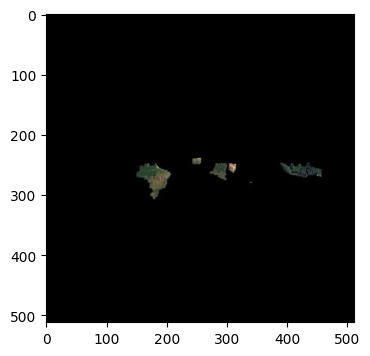

In [ ]:
def downscale_profile(profile, factor):
  transform = profile['transform']
  new_profile = profile.copy()
  new_transform = transform * transform.scale(
    (profile['width'] / factor),
    (profile['height'] / factor)
  )
  new_profile.update(transform=new_transform)
  return new_profile

def extend_profile_bounds(profile, xmin, ymin, xmax, ymax):
  transform = profile['transform']
  pixel_size_x, pixel_size_y = transform.a, -transform.e
  new_transform = from_origin(xmin, ymax, pixel_size_x, pixel_size_y)

  new_width = int((xmax - xmin) / pixel_size_x)
  new_height = int((ymax - ymin) / pixel_size_y)

  new_profile = profile.copy()
  new_profile.update(
      width=new_width,
      height=new_height,
      transform=new_transform,
      tiled=True,
      blockxsize=TILE_SIZE,
      blockysize=TILE_SIZE,
      nodata=NODATA_VALUE
    )
  return new_profile

def build_overview_profile(src_path, xmin, ymin, xmax, ymax):
  with rasterio.open(src_path) as src:
    # Downscale one zoom level past smallest overview.
    downscale_factor = src.overviews(1)[-1] * 2
    downscaled_profile = downscale_profile(src.profile, downscale_factor)
    return extend_profile_bounds(downscaled_profile, xmin, ymin, xmax, ymax), downscale_factor

def write_canvas(dst, profile):
  count = profile['count']
  width = profile['width']
  height = profile['height']
  shape = (count, height, width)
  dtype = profile['dtype']
  dst.write(np.full(shape, NODATA_VALUE, dtype))

def calculate_offsets(src, dst_profile, xmin, ymax):
  pixel_size_x, pixel_size_y = dst_profile['transform'].a, -dst_profile['transform'].e
  col = int((src.bounds.left - xmin) / pixel_size_x)
  row = int((ymax - src.bounds.top) / pixel_size_y)
  return col, row

def downscale_and_merge(src, dst, downscale_factor, xmin, ymax, profile):
  # Write the original data to the new raster at the correct location
  downscaled_height = src.height / downscale_factor
  downscaled_width = src.width / downscale_factor
  data = src.read(
    out_shape=(
      src.count,
      int(downscaled_height),
      int(downscaled_width)
    ),
    resampling=Resampling.bilinear
  )

  # Calculate the offset to paste the original data in the new raster
  col, row = calculate_offsets(src, profile, xmin, ymax)

  # Update the window in the new raster to match the original raster
  dst_window = rasterio.windows.Window(col, row, downscaled_width, downscaled_height)

  dst.write(data, window=dst_window)

def build_overview(input_paths, output_path):
  xmin, ymin, xmax, ymax = EPSG_3857_WORLD_BOUNDS
  profile, downscale_factor = build_overview_profile(input_paths[0], xmin, ymin, xmax, ymax)

  with rasterio.open(output_path, 'w', **profile) as dst:
    write_canvas(dst, profile)

    for idx, input_path in enumerate(input_paths):
      print(f"Processing image {idx} of {len(input_paths)}")
      with rasterio.open(input_path) as src:
        downscale_and_merge(src, dst, downscale_factor, xmin, ymax, profile)

src_blobs = storage_client.list_blobs(BUCKET_NAME, prefix=DEST_PREFIX)
print(BUCKET_NAME)
print(DEST_PREFIX)
paths = [x.name for x in src_blobs if '/world' not in x.name]
print(f'/vsigs_streaming/{BUCKET_NAME}/')
print(paths)
input_paths = [f'/vsigs_streaming/{BUCKET_NAME}/{fp}' for fp in paths]
tmpdir = tempfile.gettempdir()
overview_tmp_path = os.path.join(tmpdir, OVERVIEW_FILENAME)

print(input_paths)
build_overview(input_paths, overview_tmp_path)

# Build COG and upload to GCS.
build_cog(
    src_path=overview_tmp_path,
    dst_path=f"{DEST_PREFIX}/{OVERVIEW_FILENAME}"
)
show_size(overview_tmp_path)
show_thumbnail(
    f"/vsigs_streaming/{BUCKET_NAME}/{DEST_PREFIX}/{OVERVIEW_FILENAME}")

## Next steps

To use the imagery generated above in Ground, you currently need to manually add the URL to each Ground survey in should be made available:

1. Open the Ground web console.
2. Select a Survey.
3. Click the gear icon in the top-right corner and click "Edit survey".
4. Click "JSON" in the left side menu.
5. Directly under the top-level "`{`", paste in the snippet generated by running the next cell.

In [ ]:
print('''
  "tileSources": [
    {
      "url": "https://storage.googleapis.com/''' + BUCKET_NAME + '/' + DEST_PREFIX + '''"
    }
  ],
''')


  "tileSources": [
    {
      "url": "https://storage.googleapis.com/of-ground.appspot.com/offline-imagery/default/8"
    }
  ],

